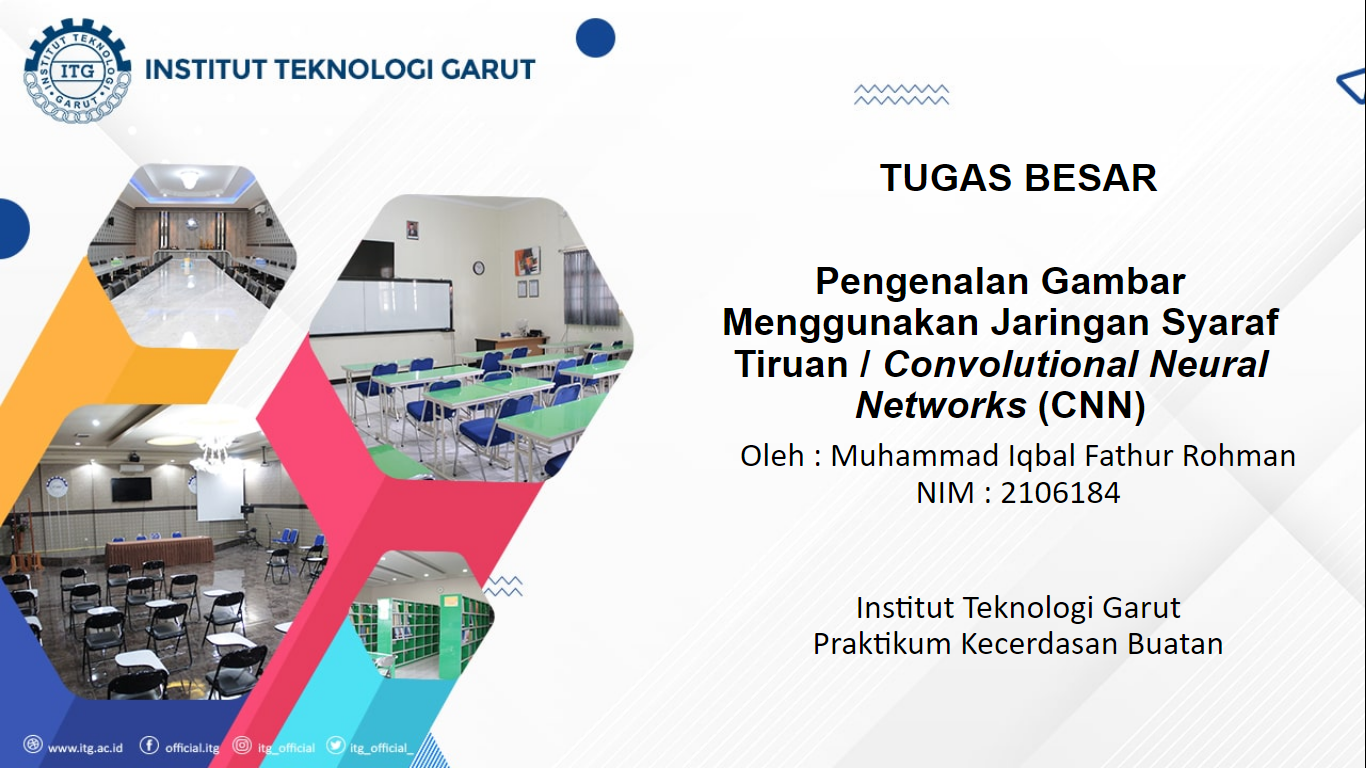

# Pengenalan gambar menggunakan Jaringan syaraf tiruan/Convolutional neural networks (CNN)

* Jaringan syaraf tiruan/Convolutional neural networks (CNN) digunakan untuk mengubah konten gambar digital menjadi vektor angka tunggal (vektor numerik) yang mewakili karakteristik unik dari gambar tersebut.
* Kolom angka tersebut dimasukkan ke dalam lapisan jaringan saraf yang terhubung penuh dengan label, gambar mana yang merupakan kucing, gambar mana yang merupakan burung, dan sebagainya.
* Model klasifikasi mempelajari input vektor numerik ini terhadap label

In [1]:
# Mengimpor Libraries
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random

# Mengimpor Libraries untuk Visualisasi Data
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Mengimport Tensorflow untuk pembuatan model dan dependencies
import tensorflow

# Menghasilkan kumpulan data gambar tensor dengan augmentasi data waktu nyata.
from keras.preprocessing.image import ImageDataGenerator

# untuk mengaktifkan inline plotting
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMAGE PRE-PROCESSING untuk data TRAINING dan TESTING

TrainingImagePath=R'/content/drive/MyDrive/TB-AI/train'
TestingImagePath=R'/content/drive/MyDrive/TB-AI/test'
ValidationImagePath=R'/content/drive/MyDrive/TB-AI/valid'

# Menentukan pre-processing gambar dari data train
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

# Menentukan pre-processing gambar dari data test
test_datagen = ImageDataGenerator(rescale=1./255)

# Menghasilkan Data Pelatihan
training_set = train_datagen.flow_from_directory(TrainingImagePath, target_size=(128, 128), batch_size=32, class_mode='categorical')

# Menghasilkan Data Testing
test_set = test_datagen.flow_from_directory(TestingImagePath, target_size=(128, 128), batch_size=32, class_mode='categorical')

# Menghasilkan Data Testing
valid_set = test_datagen.flow_from_directory(ValidationImagePath, target_size=(128, 128), batch_size=32, class_mode='categorical')

Found 650 images belonging to 13 classes.
Found 65 images belonging to 13 classes.
Found 65 images belonging to 13 classes.


### Membaca data gambar

In [4]:
# Berfungsi untuk memplot gambar acak apa pun dari dataset
def showImages(class_name):
    random_index = random.choice(list(range(1, 49)))
    folder_path=os.path.join(TrainingImagePath, class_name)
    try:
        image_path=os.path.join(folder_path,str(random_index).zfill(3)+".jpg")
        plt.imshow(mpimg.imread(image_path))
    except:
        image_path=os.path.join(folder_path,str(random_index).zfill(2)+".jpg")
        plt.imshow(mpimg.imread(image_path))
    plt.title(class_name)
    plt.axis(False)

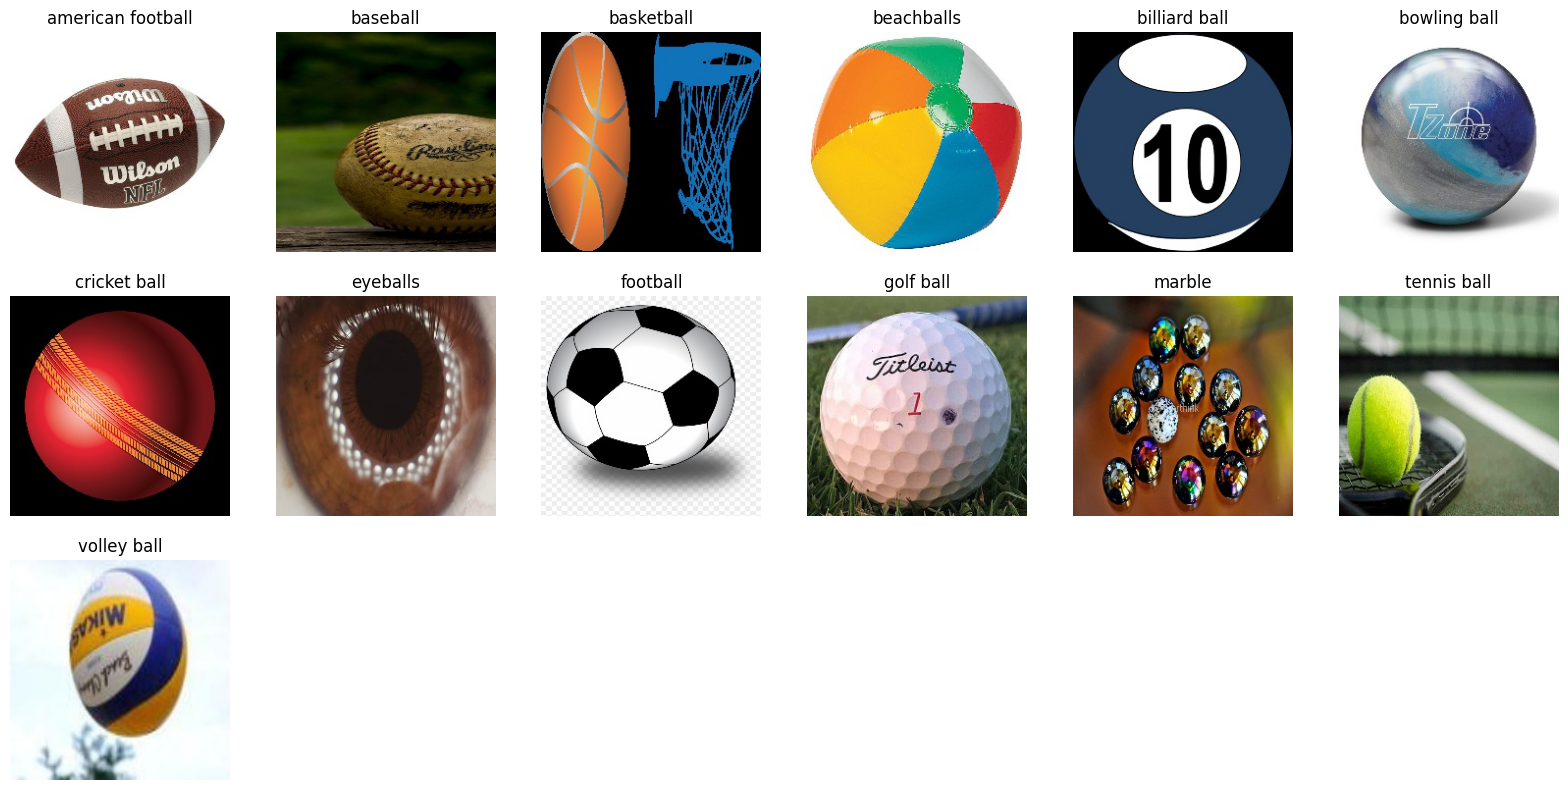

In [5]:
plt.figure(figsize = (20,20))
for labels,number in training_set.class_indices.items():
    plt.subplot(6,6,number+1)
    showImages(labels)


In [6]:
# Mencetak label kelas
test_set.class_indices

{'american football': 0,
 'baseball': 1,
 'basketball': 2,
 'beachballs': 3,
 'billiard ball': 4,
 'bowling ball': 5,
 'cricket ball': 6,
 'eyeballs': 7,
 'football': 8,
 'golf ball': 9,
 'marble': 10,
 'tennis ball': 11,
 'volley ball': 12}

### Membuat daftar muka dan kelas

In [7]:
# class_indices memiliki tag numerik untuk setiap bola
TrainClasses=training_set.class_indices

# Menyimpan muka dan tag numerik untuk referensi di masa mendatang
ResultMap={}
for ballValue,ballName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[ballValue]=ballName

# Menyimpan peta muka untuk referensi di masa mendatang
import pickle
with open(R"./ResultsMap.pkl", 'wb') as f:
    pickle.dump(ResultMap, f, pickle.HIGHEST_PROTOCOL)

print("Pemetaan muka dan Identitasnya",ResultMap)

# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n Jumlah output neuron : ', OutputNeurons)

Pemetaan muka dan Identitasnya {0: 'american football', 1: 'baseball', 2: 'basketball', 3: 'beachballs', 4: 'billiard ball', 5: 'bowling ball', 6: 'cricket ball', 7: 'eyeballs', 8: 'football', 9: 'golf ball', 10: 'marble', 11: 'tennis ball', 12: 'volley ball'}

 Jumlah output neuron :  13


### Membuat model Jaringan Syaraf Tiruan

In [8]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Inisialisasi Jaringan Syaraf Tiruan
classifier= Sequential()

classifier.add(Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128,128,3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Convolution2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(256, activation='relu'))
classifier.add(Dense(OutputNeurons, activation='softmax'))

# Mengonpilasi model
classifier.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=["accuracy"])

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               1

### Melatih model

In [10]:
import time
# Mengukur waktu yang dibutuhkan oleh model untuk berlatih
StartTime=time.time()

# Memulai pelatihan model
model_history=classifier.fit_generator(
                                        training_set,
                                        steps_per_epoch=len(training_set),
                                        epochs=20,
                                        validation_data=valid_set,
                                        validation_steps=len(valid_set),
                                        verbose=1)

EndTime=time.time()
print("############### Total Waktu yang Dibutuhkan: ", round((EndTime-StartTime)/60), 'Menit #############')

<ipython-input-10-e70366bd7cb7>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=classifier.fit_generator(


Epoch 1/20
21/21 [==============================] - 477s 22s/step - loss: 3.6055 - accuracy: 0.1600 - val_loss: 2.0460 - val_accuracy: 0.4154
Epoch 2/20
21/21 [==============================] - 5s 249ms/step - loss: 1.9678 - accuracy: 0.4062 - val_loss: 1.7775 - val_accuracy: 0.4154
Epoch 3/20
21/21 [==============================] - 4s 206ms/step - loss: 1.7043 - accuracy: 0.4569 - val_loss: 1.5194 - val_accuracy: 0.5846
Epoch 4/20
21/21 [==============================] - 5s 245ms/step - loss: 1.3181 - accuracy: 0.6169 - val_loss: 1.3684 - val_accuracy: 0.5692
Epoch 5/20
21/21 [==============================] - 4s 212ms/step - loss: 1.1529 - accuracy: 0.6338 - val_loss: 1.5292 - val_accuracy: 0.5692
Epoch 6/20
21/21 [==============================] - 6s 277ms/step - loss: 0.9286 - accuracy: 0.7062 - val_loss: 1.0040 - val_accuracy: 0.6923
Epoch 7/20
21/21 [==============================] - 5s 214ms/step - loss: 0.7812 - accuracy: 0.7662 - val_loss: 1.0576 - val_accuracy: 0.6923
Epoch 

In [11]:
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

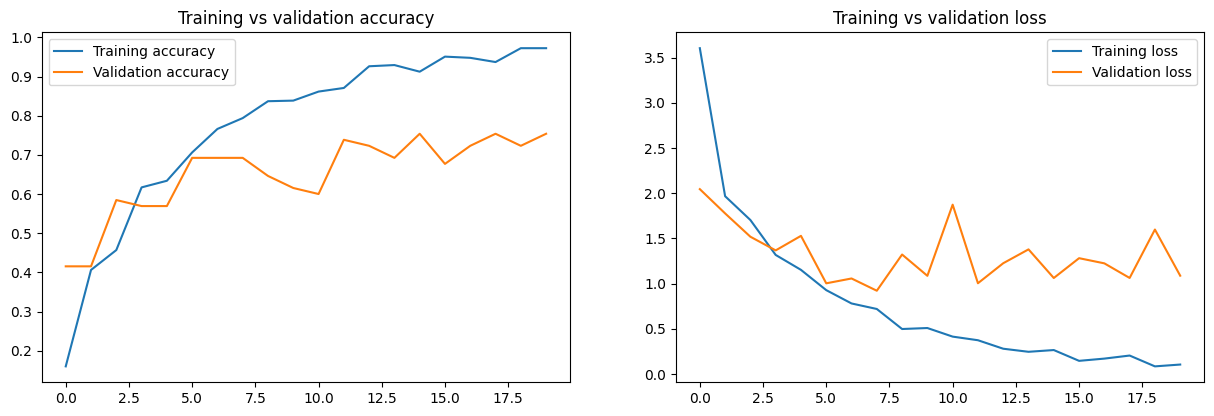

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Menyimpan hasil model

In [13]:
## Menyimpan model
classifier.save(R"/classifier.pkl")

### Menguji model pada muka yang berbeda

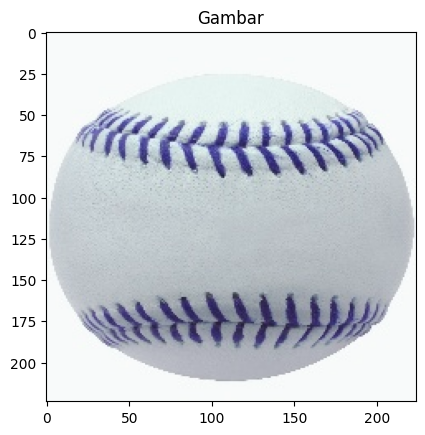

########################################
Prediksinya adalah:  baseball


In [14]:
# Membuat prediksi tunggal
from tensorflow.keras.utils import load_img, img_to_array

testImage=R"/content/drive/MyDrive/TB-AI/test/baseball/2.jpg"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)
img = cv2.imread(testImage)
plt.imshow(img)
plt.title('Gambar')
plt.show()

print('####'*10)
print('Prediksinya adalah: ',ResultMap[np.argmax(result)])

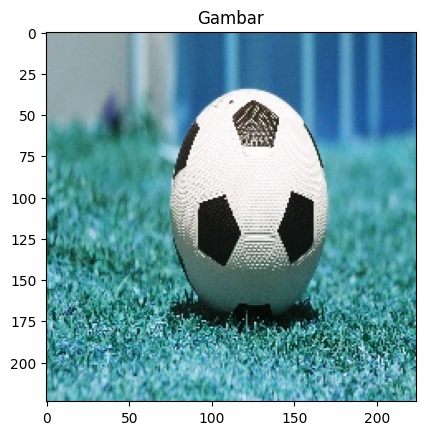

########################################
Prediksinya adalah:  football


In [18]:
testImage=R"/content/drive/MyDrive/TB-AI/test/football/1.jpg"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)
img = cv2.imread(testImage)
plt.imshow(img)
plt.title('Gambar')
plt.show()

print('####'*10)
print('Prediksinya adalah: ',ResultMap[np.argmax(result)])

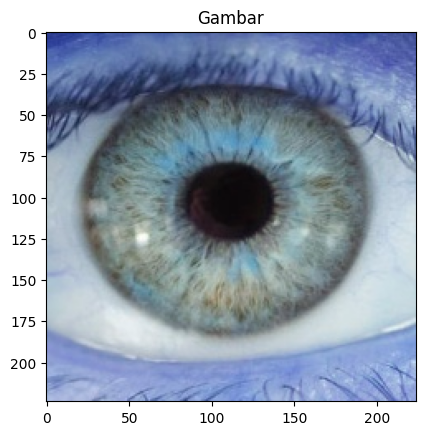

########################################
Prediksinya adalah:  eyeballs


In [25]:
testImage=R"/content/drive/MyDrive/TB-AI/test/eyeballs/1.jpg"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)
img = cv2.imread(testImage)
plt.imshow(img)
plt.title('Gambar')
plt.show()

print('####'*10)
print('Prediksinya adalah: ',ResultMap[np.argmax(result)])

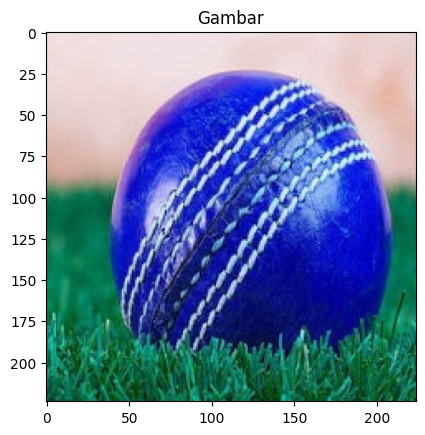

########################################
Prediksinya adalah:  cricket ball


In [23]:
testImage=R"/content/drive/MyDrive/TB-AI/test/cricket ball/1.jpg"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)
img = cv2.imread(testImage)
plt.imshow(img)
plt.title('Gambar')
plt.show()

print('####'*10)
print('Prediksinya adalah: ',ResultMap[np.argmax(result)])